In [1]:
import pandas as pd
import json
import pandas as pd
import cv2
import numpy as np
from enum import Enum, auto
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append("../Skin_segmentation")
sys.path.append("../../Models")

from Skindetector import *
from rPPGNet import rPPGNet

with open("../../Data/json_structure") as json_file:
    data = json.load(json_file)


root_dir = "/work3/s174159/data/"
video_file = root_dir + "00/02/c920-1.avi"
bb_file = root_dir + "bbox/00/02/c920-1.face"
ecg_path = root_dir + "00/02/viatom-raw.csv"
index_path = root_dir + "00/02/c920.csv"

bb_data = pd.read_csv(
    bb_file, sep=" ", header=None, names=["frame", "x", "y", "w", "h"]
).drop("frame", axis=1)
lead_rate = 500

In [ ]:
cap = cv2.VideoCapture(video_file)

In [ ]:
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
durationInSeconds = length / fps
print(f"length in frames: {length}, FPS:{fps}, duration(S): {durationInSeconds}")

In [3]:
df = pd.read_csv(ecg_path)
df.head(5)

,milliseconds,ECG,ECG HR,PPG,PPG HR,SpO2,PI
0,1523629930125,720896,78,-56,-1,-1,0
1,1523629930125,589824,78,-56,-1,-1,0
2,1523629930125,589824,78,-56,-1,-1,0
3,1523629930125,655360,78,-56,-1,-1,0
4,1523629930125,655360,78,-56,-1,-1,0


In [ ]:
lead_names = ["Lead I", "Lead II", "Lead III", "Lead aVR", "Lead aVL"]

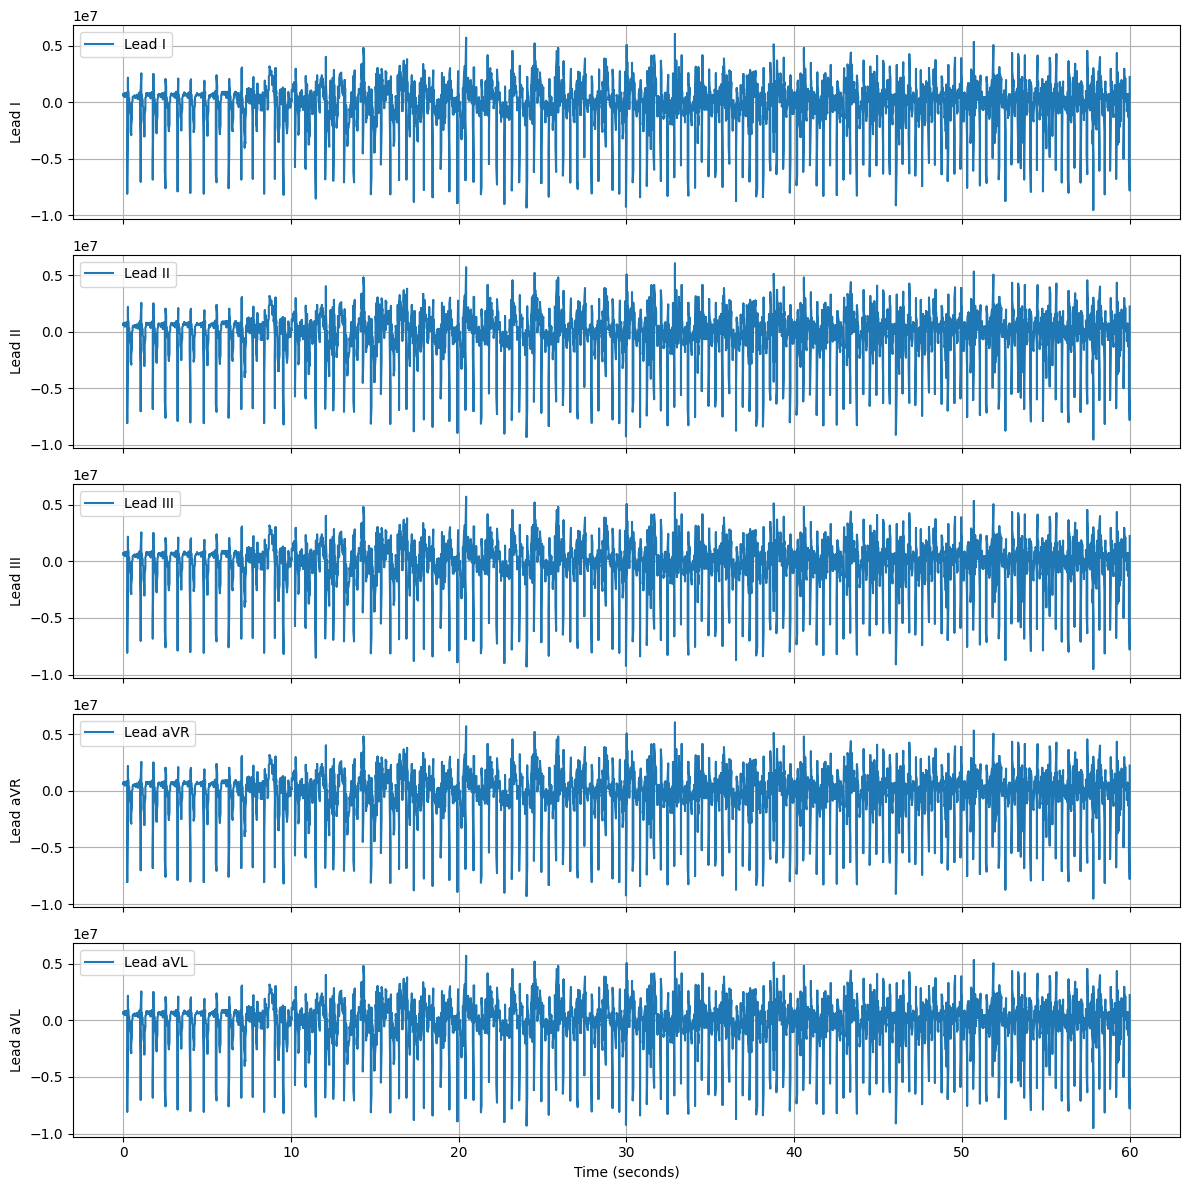

In [7]:
# Convert milliseconds to time in seconds
df["time"] = (df["milliseconds"] - df["milliseconds"].min()) / 1000

# Create 5 subplots for the ECG leads
fig, axes = plt.subplots(5, 1, figsize=(12, 12), sharex=True, sharey=True)

lead_names = ["Lead I", "Lead II", "Lead III", "Lead aVR", "Lead aVL"]

for i, ax in enumerate(axes):
    lead_data = df[df["time"] < 60]  # Adjust the time range if needed
    ax.plot(lead_data["time"], lead_data[" ECG"], label=lead_names[i])
    ax.set_ylabel(lead_names[i])
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Time (seconds)")
plt.tight_layout()
plt.show()

In [ ]:
df["Lead"] = lead_names * (len(df) // 5)
df["time"] = (df["milliseconds"] - df["milliseconds"].min()) / 1000  # Convert time.
tmp_df = df[df["Lead"] == "Lead II"]
tmp_df[" ECG"] = tmp_df[" ECG"] * 1e-8

In [ ]:
index_df = pd.read_csv(index_path, header=None, names=["timestamp", "idx_signal"])

In [ ]:
len(tmp_df)
index_df

In [1]:
df = tmp_df.loc[index_df.iloc[0].idx_signal :]
df

NameError: name 'tmp_df' is not defined

In [ ]:
import scipy

test_df = scipy.signal.resample(df[" ECG"], 1800)

In [ ]:
timedif = abs(df.head(1)["time"].values[0] - df.tail(1)["time"].values[0])

In [ ]:
len(df) / timedif

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(df["time"], df[" ECG"])
plt.show()

In [ ]:
def moving_average(series, window_size=5):
    # Convert array of integers to pandas series

    # Get the window of series
    # of observations of specified window size
    windows = series.rolling(window_size)

    # Create a series of moving
    # averages of each window
    moving_averages = windows.mean()

    # Convert pandas series back to list
    moving_averages_list = moving_averages.tolist()
    final_list = moving_averages_list
    return final_list


df["ECG NORM"] = (df[" ECG"] - np.min(df[" ECG"])) / (
    np.max(df[" ECG"]) - np.min(df[" ECG"])
)
df["ECG MV"] = moving_average(df["ECG NORM"], 3)

In [ ]:
def moving_average(series, window_size=5):
    # Convert array of integers to pandas series

    # Get the window of series
    # of observations of specified window size
    windows = series.rolling(window_size)

    # Create a series of moving
    # averages of each window
    moving_averages = windows.mean()

    # Convert pandas series back to list
    moving_averages_list = moving_averages.tolist()
    final_list = moving_averages_list
    return final_list


tmp_df["ECG NORM"] = (tmp_df[" ECG"] - np.min(tmp_df[" ECG"])) / (
    np.max(tmp_df[" ECG"]) - np.min(tmp_df[" ECG"])
)
tmp_df["ECG MV"] = moving_average(tmp_df["ECG NORM"], 3)

In [ ]:
plt.figure(figsize=(20, 10))
# plt.plot(tmp_df["time"], tmp_df[" ECG"])
plt.plot(df["time"], df["ECG NORM"], color="r")
plt.plot(df["time"], df["ECG MV"], color="b")
plt.legend(["ECG NORM", "ECG MV"])
plt.title("Moving vs normalized ECG")
plt.show()

## Full Peak Detection

In [ ]:
plt.plot(test_df)
plt.xlim(0, 64)

In [ ]:
test_df

In [ ]:
import heartpy as hp

hrdata = df["ECG NORM"]
len(hrdata)

In [ ]:
print(len(hrdata) / durationInSeconds)

In [ ]:
# Load example data
working_data, measures = hp.process(hrdata, sample_rate=15)
hp.plotter(working_data=working_data, measures=measures)

In [ ]:
tmp_df[" ECG HR"].mean()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(tmp_df["time"], tmp_df[" ECG"])
plt.scatter(rpeaks, tmp_df[" ECG"].iloc[rpeaks], marker="x", color="red", label="X")
plt.xlim(0, 6)
plt.show()

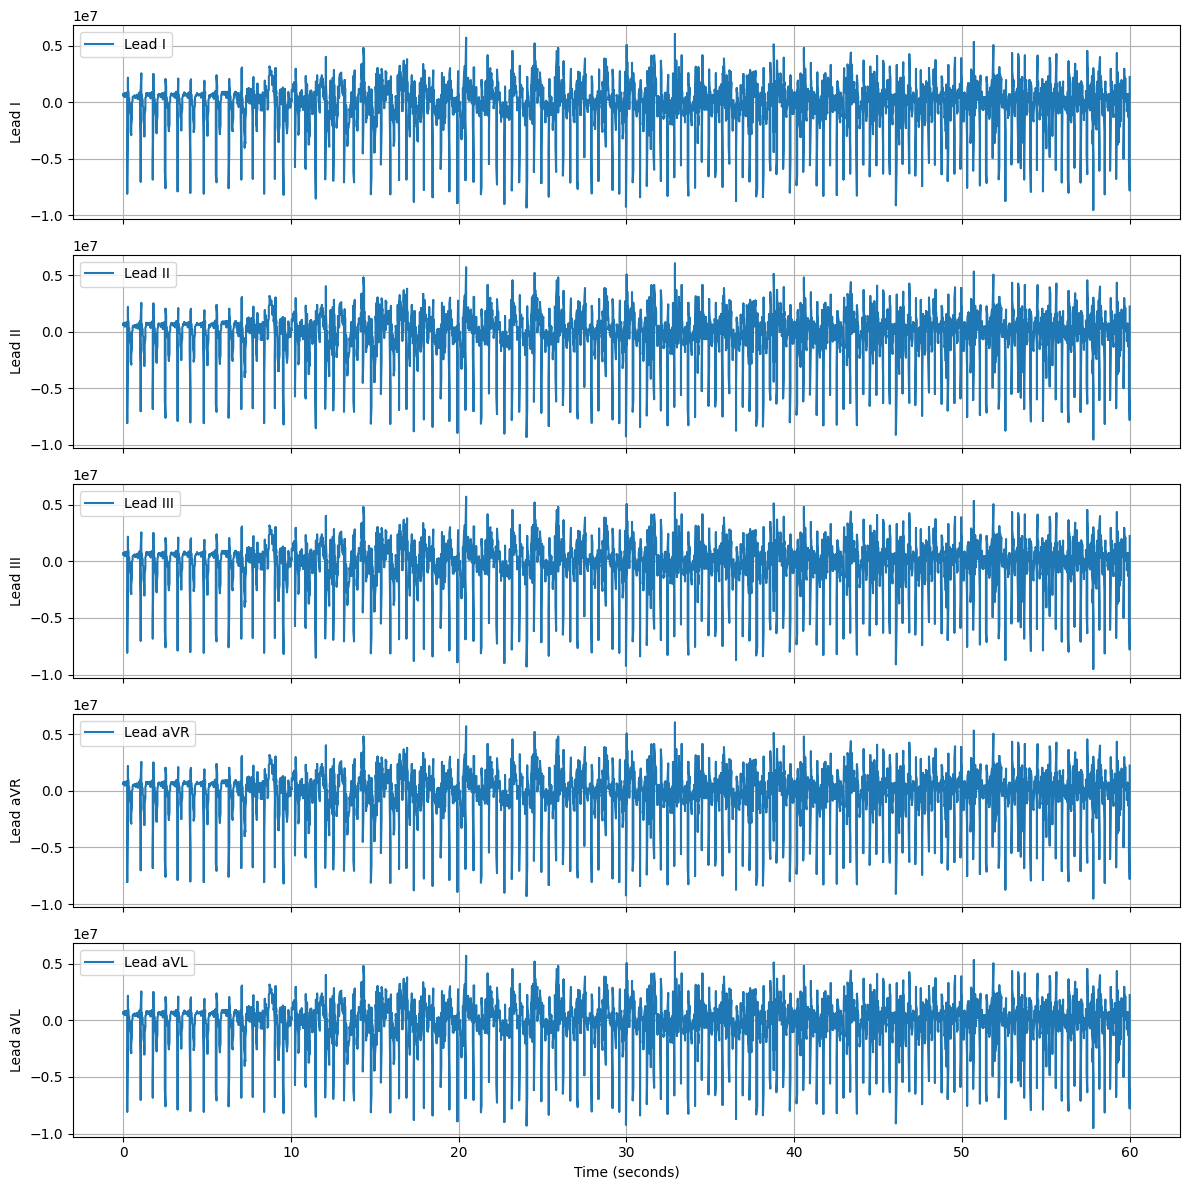

In [5]:
# Convert milliseconds to time in seconds
df["time"] = (df["milliseconds"] - df["milliseconds"].min()) / 1000

# Create 5 subplots for the ECG leads
fig, axes = plt.subplots(5, 1, figsize=(12, 12), sharex=True, sharey=True)

lead_names = ["Lead I", "Lead II", "Lead III", "Lead aVR", "Lead aVL"]

for i, ax in enumerate(axes):
    lead_data = df[df["time"] < 60]  # Adjust the time range if needed
    ax.plot(lead_data["time"], lead_data[" ECG"], label=lead_names[i])
    ax.set_ylabel(lead_names[i])
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Time (seconds)")
plt.tight_layout()
plt.show()